In [352]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler


# Data && Parameter settings

### Hyper parameters

In [353]:
interval = '4h'
shift_interval = -4 # 몇 번째 후를 예측할지
patience = 50
lr = 0.0002
epochs = 400

In [354]:
# Load data
btc_data = pd.read_csv(f'data/btc_{interval}_data_with_ma.csv', index_col=False, parse_dates=['timestamp'])
btc_data['timestamp'] = pd.to_datetime(btc_data['timestamp'])

In [355]:
# scenario 2: bear only
# btc_data = btc_data[(btc_data['timestamp'] >= '2021-11-10') & (btc_data['timestamp'] <= '2023-01-05')]

In [356]:
def calculate_rsi(df, window=14):
    delta = df['close'].diff(1)  # Price changes between each day
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()  # Calculate average gains
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()  # Calculate average losses
    rs = gain / loss  # Relative Strength (RS)
    rsi = 100 - (100 / (1 + rs))  # RSI formula
    df['rsi'] = rsi
    return df

In [357]:
btc_data = calculate_rsi(btc_data)

# MACD

In [358]:
btc_data['EMA_12'] = btc_data['close'].ewm(span=12, adjust=False).mean()
btc_data['EMA_26'] = btc_data['close'].ewm(span=26, adjust=False).mean()

# Calculate MACD Line
btc_data['MACD_Line'] = btc_data['EMA_12'] - btc_data['EMA_26']

# Calculate Signal Line (9-period EMA of MACD Line)
btc_data['Signal_Line'] = btc_data['MACD_Line'].ewm(span=9, adjust=False).mean()

# Calculate MACD Histogram
btc_data['MACD_Histogram'] = btc_data['MACD_Line'] - btc_data['Signal_Line']

btc_data = btc_data.drop(columns=['EMA_12', 'EMA_26'])

In [359]:
features = ['open', 'high', 'low', 'close', 'volume', 'rsi']
features_MACD = ['MACD_Line', 'Signal_Line', 'MACD_Histogram']
features_MA = ['MA_30', 'MA_60', 'MA_90', 'MA_120', 'MA_250', 'MA_260', 'MA_1020'] # for 4h
# features_MA = ['MA_40', 'MA_60', 'MA_90', 'MA_120', 'MA_200'] # for 1h or 15m chart
features += features_MACD + features_MA 

In [360]:
btc_data.head()

,timestamp,open,high,low,close,volume,MA_10,MA_20,MA_30,MA_50,...,MA_1010,MA_1020,MA_1030,MA_1040,MA_1050,MA_1060,rsi,MACD_Line,Signal_Line,MACD_Histogram
0,2017-08-17 04:00:00,4261.48,4349.99,4261.32,4349.99,82.088865,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000
1,2017-08-17 08:00:00,4333.32,4485.39,4333.32,4427.30,63.619882,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.167179,1.233436,4.933744
2,2017-08-17 12:00:00,4436.06,4485.39,4333.42,4352.34,174.562001,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.949019,1.976553,2.972466
3,2017-08-17 16:00:00,4352.33,4354.84,4200.74,4325.23,225.109716,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.775599,1.936362,-0.160762
4,2017-08-17 20:00:00,4307.56,4369.69,4258.56,4285.08,249.769913,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.933782,0.762333,-4.696115


# Shift data (predict next close)

In [361]:
# Shift the 'close' column values forward by one space
btc_data['next_close'] = btc_data['close'].shift(shift_interval)

# Display the first few rows to check the result
# btc_data[['timestamp', 'close', 'close_shifted']].head()
features += ['next_close']

## Processing Nan data

In [362]:
data_filled = btc_data.ffill()
data_filled = data_filled.bfill()
data_filled = data_filled.dropna()

# Get the maximum window size from MA columns
ma_columns = features_MA
ma_window_sizes = [int(col.split('_')[1]) for col in features_MA]
max_ma_window = max(ma_window_sizes) # 1020

# Remove the initial rows where moving averages are NaN
# data_cleaned = btc_data.iloc[max_ma_window:]

In [363]:
data_filled.tail()

,timestamp,open,high,low,close,volume,MA_10,MA_20,MA_30,MA_50,...,MA_1020,MA_1030,MA_1040,MA_1050,MA_1060,rsi,MACD_Line,Signal_Line,MACD_Histogram,next_close
15678,2024-10-14 20:00:00,65939.41,66500.0,65730.0,66083.99,3881.13909,64212.929,63547.3645,62651.340667,62591.3946,...,62769.402784,62775.463068,62789.609058,62822.391305,62849.214302,76.811137,953.159559,607.171790,345.987769,67571.8
15679,2024-10-15 00:00:00,66084.00,66330.0,65324.4,65400.00,3574.82599,64496.796,63663.0640,62802.497667,62646.7670,...,62770.754137,62776.585379,62790.978231,62821.405581,62849.370896,70.052957,960.650095,677.867451,282.782645,67571.8
15680,2024-10-15 04:00:00,65399.99,65846.0,65201.0,65638.74,3319.36953,64837.739,63818.0010,62960.455667,62703.1436,...,62772.443588,62778.658699,62792.275490,62820.966486,62849.932264,70.214870,974.615957,737.217152,237.398805,67571.8
15681,2024-10-15 08:00:00,65638.74,65850.0,65280.0,65399.69,3798.65244,65104.276,63959.5855,63098.378667,62740.5272,...,62774.321706,62780.268058,62793.350183,62820.352867,62850.745179,73.320664,955.381620,780.850046,174.531575,67571.8
15682,2024-10-15 12:00:00,65399.68,67950.0,65383.5,67571.80,6878.70128,65574.454,64199.7970,63324.460000,62821.3234,...,62778.274451,62783.959117,62796.767308,62821.450238,62853.226925,80.299100,1102.698176,845.219672,257.478504,67571.8


# Scaling

In [364]:
scaler = MinMaxScaler()
# scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data_filled[features])

In [365]:
data_filled.head()

,timestamp,open,high,low,close,volume,MA_10,MA_20,MA_30,MA_50,...,MA_1020,MA_1030,MA_1040,MA_1050,MA_1060,rsi,MACD_Line,Signal_Line,MACD_Histogram,next_close
0,2017-08-17 04:00:00,4261.48,4349.99,4261.32,4349.99,82.088865,4304.606,4191.461,4142.801667,4137.9686,...,8553.405137,8557.07733,8543.852808,8535.998981,8536.229708,22.66832,0.000000,0.000000,0.000000,4285.08
1,2017-08-17 08:00:00,4333.32,4485.39,4333.32,4427.30,63.619882,4304.606,4191.461,4142.801667,4137.9686,...,8553.405137,8557.07733,8543.852808,8535.998981,8536.229708,22.66832,6.167179,1.233436,4.933744,4292.39
2,2017-08-17 12:00:00,4436.06,4485.39,4333.42,4352.34,174.562001,4304.606,4191.461,4142.801667,4137.9686,...,8553.405137,8557.07733,8543.852808,8535.998981,8536.229708,22.66832,4.949019,1.976553,2.972466,4300.25
3,2017-08-17 16:00:00,4352.33,4354.84,4200.74,4325.23,225.109716,4304.606,4191.461,4142.801667,4137.9686,...,8553.405137,8557.07733,8543.852808,8535.998981,8536.229708,22.66832,1.775599,1.936362,-0.160762,4340.31
4,2017-08-17 20:00:00,4307.56,4369.69,4258.56,4285.08,249.769913,4304.606,4191.461,4142.801667,4137.9686,...,8553.405137,8557.07733,8543.852808,8535.998981,8536.229708,22.66832,-3.933782,0.762333,-4.696115,4236.89


In [366]:
scaled_data.shape

(15683, 17)

In [367]:
scaled_data

array([[0.0197306 , 0.01701836, 0.02063226, ..., 0.00839376, 0.07321382,
        0.01939621],
       [0.02074992, 0.01893542, 0.02166079, ..., 0.00839376, 0.07321382,
        0.0195    ],
       [0.02220767, 0.01893542, 0.02166221, ..., 0.00839376, 0.07321382,
        0.0196116 ],
       ...,
       [0.88721003, 0.88770901, 0.89116181, ..., 0.89052223, 0.9654588 ,
        0.91796933],
       [0.89059759, 0.88776565, 0.89229033, ..., 0.89097939, 0.96548971,
        0.91796933],
       [0.88720563, 0.91749848, 0.89376884, ..., 0.8915778 , 0.96555476,
        0.91796933]])

# Sequences

In [368]:
def create_sequences(data, sequence_length=10):
    X = []
    y = []
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i])
        # y.append(data[i, features.index('close')])
        y.append(data[i, features.index('next_close')])
    return np.array(X), np.array(y)

sequence_length = 1
X, y = create_sequences(scaled_data, sequence_length)

In [369]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [370]:
X_train.shape

(12545, 1, 17)

In [371]:
y_train.shape

(12545,)

In [372]:
X_test.shape

(3137, 1, 17)

In [373]:
y_test.shape

(3137,)

In [374]:
btc_data.tail()

,timestamp,open,high,low,close,volume,MA_10,MA_20,MA_30,MA_50,...,MA_1020,MA_1030,MA_1040,MA_1050,MA_1060,rsi,MACD_Line,Signal_Line,MACD_Histogram,next_close
15678,2024-10-14 20:00:00,65939.41,66500.0,65730.0,66083.99,3881.13909,64212.929,63547.3645,62651.340667,62591.3946,...,62769.402784,62775.463068,62789.609058,62822.391305,62849.214302,76.811137,953.159559,607.171790,345.987769,67571.8
15679,2024-10-15 00:00:00,66084.00,66330.0,65324.4,65400.00,3574.82599,64496.796,63663.0640,62802.497667,62646.7670,...,62770.754137,62776.585379,62790.978231,62821.405581,62849.370896,70.052957,960.650095,677.867451,282.782645,NaN
15680,2024-10-15 04:00:00,65399.99,65846.0,65201.0,65638.74,3319.36953,64837.739,63818.0010,62960.455667,62703.1436,...,62772.443588,62778.658699,62792.275490,62820.966486,62849.932264,70.214870,974.615957,737.217152,237.398805,NaN
15681,2024-10-15 08:00:00,65638.74,65850.0,65280.0,65399.69,3798.65244,65104.276,63959.5855,63098.378667,62740.5272,...,62774.321706,62780.268058,62793.350183,62820.352867,62850.745179,73.320664,955.381620,780.850046,174.531575,NaN
15682,2024-10-15 12:00:00,65399.68,67950.0,65383.5,67571.80,6878.70128,65574.454,64199.7970,63324.460000,62821.3234,...,62778.274451,62783.959117,62796.767308,62821.450238,62853.226925,80.299100,1102.698176,845.219672,257.478504,NaN


In [375]:
print(f"Type of X_train: {type(X_train)}")
print(f"Shape of X_train: {X_train.shape}")
print(f"Data type of X_train elements: {X_train.dtype}")

Type of X_train: <class 'numpy.ndarray'>
Shape of X_train: (12545, 1, 17)
Data type of X_train elements: float64


# Check NaN

In [376]:
def check_for_nans_and_infs(data, name):
    nan_count = np.isnan(data).sum()
    inf_count = np.isinf(data).sum()
    print(f"{name} - NaNs: {nan_count}, Infs: {inf_count}")

# Check X_train
check_for_nans_and_infs(X_train, 'X_train')

# Check y_train
check_for_nans_and_infs(y_train, 'y_train')

# Check X_test
check_for_nans_and_infs(X_test, 'X_test')

# Check y_test
check_for_nans_and_infs(y_test, 'y_test')
check_for_nans_and_infs(scaled_data, 'scaled_data')


X_train - NaNs: 0, Infs: 0
y_train - NaNs: 0, Infs: 0
X_test - NaNs: 0, Infs: 0
y_test - NaNs: 0, Infs: 0
scaled_data - NaNs: 0, Infs: 0


# Model & train (Keras)

In [377]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Define the model
model = Sequential()
model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(32, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32))
model.add(Dropout(0.2))
model.add(Dense(1))

optimizer = Adam(learning_rate=lr)
model.compile(optimizer=optimizer, loss='mean_squared_error')

early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=epochs, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/400
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0667 - val_loss: 6.1880e-04
Epoch 2/400
314/314 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step - loss: 0.0037 - val_loss: 7.5375e-04
Epoch 3/400
314/314 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step - loss: 0.0031 - val_loss: 6.9475e-04
Epoch 4/400
314/314 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step - loss: 0.0029 - val_loss: 4.0903e-04
Epoch 5/400
314/314 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step - loss: 0.0026 - val_loss: 2.5469e-04
Epoch 6/400
314/314 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - loss: 0.0022 - val_loss: 1.9741e-04
Epoch 7/400
314/314 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step - loss: 0.0022 - val_loss: 1.8096e-04
Epoch 8/400
314/314 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step - loss: 0.0020 - val_loss: 1.5143e-04
Epoch 9/400
314/314 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step - loss: 0.0019 - val_loss: 1.3901e-04
Epoch 10/400
314/314 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step - loss: 0.0017 - val_loss: 1.9455e-04
Epoch 11/400
314/314 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step - loss: 0.0017 

# Model & train (torch)

In [378]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import TensorDataset, DataLoader
# import numpy as np

# # Assuming you have variables `X_train`, `y_train`, `lr`, `epochs`, and `patience` defined
# # Convert your training data to PyTorch tensors
# X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
# y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

# # Calculate the split index for sequential splitting
# validation_split = 0.2  # Same as validation_split=0.2 in Keras
# dataset_size = len(X_train_tensor)
# split_index = int(dataset_size * (1 - validation_split))

# # Sequentially split the data
# X_train_seq = X_train_tensor[:split_index]
# y_train_seq = y_train_tensor[:split_index]
# X_val_seq = X_train_tensor[split_index:]
# y_val_seq = y_train_tensor[split_index:]

# # Create TensorDatasets
# train_dataset = TensorDataset(X_train_seq, y_train_seq)
# val_dataset = TensorDataset(X_val_seq, y_val_seq)

# # Create DataLoaders for batching without shuffling
# batch_size = 32
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
# val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# # Define the LSTM model
# class LSTMModel(nn.Module):
#     def __init__(self, input_size, hidden_size=50, dropout_rate=0.2):
#         super(LSTMModel, self).__init__()
#         self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True)
#         self.dropout1 = nn.Dropout(dropout_rate)
#         self.lstm2 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
#         self.dropout2 = nn.Dropout(dropout_rate)
#         self.fc = nn.Linear(hidden_size, 1)

#     def forward(self, x):
#         # First LSTM layer with return_sequences=True
#         out, _ = self.lstm1(x)
#         out = self.dropout1(out)
#         # Second LSTM layer
#         out, _ = self.lstm2(out)
#         out = out[:, -1, :]  # Take the output of the last time step
#         out = self.dropout2(out)
#         # Fully connected layer
#         out = self.fc(out)
#         return out

# # Initialize the model, loss function, and optimizer
# input_size = X_train.shape[2]  # Number of features
# model = LSTMModel(input_size=input_size, hidden_size=50, dropout_rate=0.2)

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# # device = torch.device("mps" if torch.backends.mps.is_built() or torch.backends.mps.is_available() else 'cpu')
# model.to(device)

# criterion = nn.MSELoss()
# optimizer = optim.Adam(model.parameters(), lr=lr)

# # Implement early stopping
# best_val_loss = float('inf')
# patience_counter = 0
# best_model_state = None

# train_loss_history = []
# val_loss_history = []

# for epoch in range(epochs):
#     # Training phase
#     model.train()
#     train_losses = []
#     for X_batch, y_batch in train_loader:
#         X_batch = X_batch.to(device)
#         y_batch = y_batch.to(device)

#         optimizer.zero_grad()
#         outputs = model(X_batch)
#         loss = criterion(outputs.view(-1), y_batch)
#         loss.backward()
#         optimizer.step()

#         train_losses.append(loss.item())

#     avg_train_loss = np.mean(train_losses)
#     train_loss_history.append(avg_train_loss)

#     # Validation phase
#     model.eval()
#     val_losses = []
#     with torch.no_grad():
#         for X_batch, y_batch in val_loader:
#             X_batch = X_batch.to(device)
#             y_batch = y_batch.to(device)

#             outputs = model(X_batch)
#             loss = criterion(outputs.view(-1), y_batch)
#             val_losses.append(loss.item())

#     avg_val_loss = np.mean(val_losses)
#     val_loss_history.append(avg_val_loss)

#     print(f"Epoch {epoch+1}/{epochs}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

#     # Check for early stopping
#     if avg_val_loss < best_val_loss:
#         best_val_loss = avg_val_loss
#         best_model_state = model.state_dict()
#         patience_counter = 0
#     else:
#         patience_counter += 1
#         if patience_counter >= patience:
#             print("Early stopping triggered")
#             break

# # Restore the best model weights
# model.load_state_dict(best_model_state)

## Figure

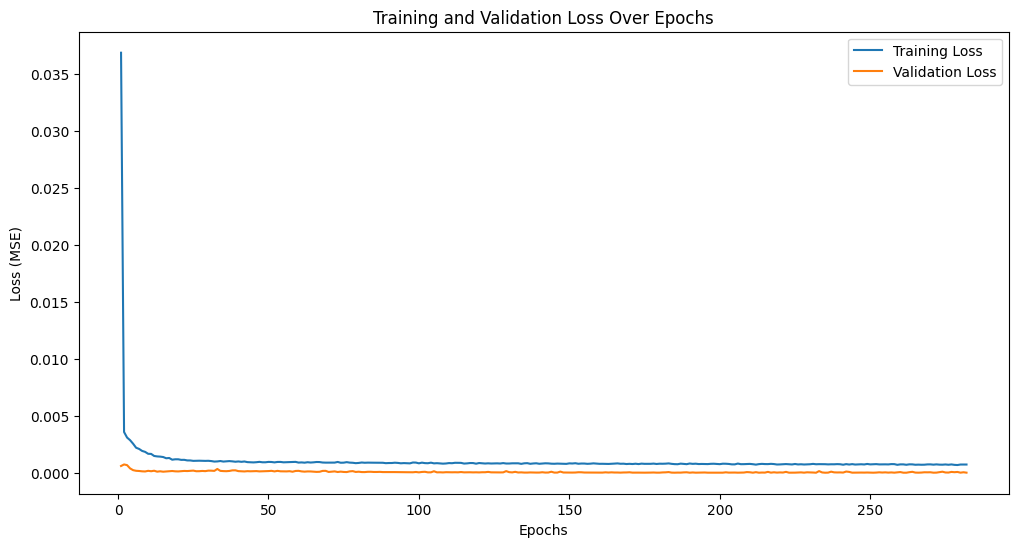

In [379]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))  # Size up the figure

# epochs_range = range(1, len(train_loss_history) + 1)  # Get the range of epochs
# plt.plot(epochs_range, train_loss_history, label='Training Loss')
# plt.plot(epochs_range, val_loss_history, label='Validation Loss')

epochs = range(1, len(history.history['loss']) + 1)  # Get number of epochs

plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')

plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')  # Annotate x-axis with epochs
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

#

# Prediction

In [380]:
# Ensure that your model is in evaluation mode
# model.eval()

# Convert X_test to a PyTorch tensor and move it to the appropriate device
# X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)

# Make predictions without computing gradients
# with torch.no_grad():
    # y_pred = model(X_test_tensor)

# Move predictions to CPU and convert to NumPy array
# y_pred = y_pred.cpu().numpy()

y_pred = model.predict(X_test)

# Get the index of 'next_close' in the features list
close_index = features.index('next_close')

# Retrieve the min and max values for 'next_close' from the scaler
close_min = scaler.data_min_[close_index]
close_max = scaler.data_max_[close_index]

# Inverse transform the scaled 'close' prices
y_test_actual = y_test * (close_max - close_min) + close_min
y_pred_actual = y_pred[:, 0] * (close_max - close_min) + close_min

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


# Backtesting

In [381]:
initial_balance = 10000  # Starting with $10,000
balance = initial_balance
btc_holdings = 0
positions = []

btc_data_tail_df = btc_data.tail(y_test.shape[0])
base_price = btc_data_tail_df['close'].iloc[0]
final_price = btc_data_tail_df['close'].iloc[-1]
base_portfolio_value = ((final_price - base_price) / base_price + 1) * initial_balance
print(f"Baseline portfilio value: {base_portfolio_value:,.2f} USDT")  

for i in range(len(y_pred_actual)):
    current_time = btc_data_tail_df['timestamp'].iloc[i]
    predicted_price = y_pred_actual[i]
    # current_price = y_test_actual[i]
    current_price = btc_data_tail_df['close'].iloc[i]

    if predicted_price > current_price:
        # Buy signal
        if balance > 0:
            btc_holdings = balance / current_price
            balance = 0
            positions.append(('Buy', current_price))
            print(f"{current_time}: Bought BTC at {current_price:,.2f}, holding {btc_holdings:.4f} BTC")
    else:
        # Sell signal
        if btc_holdings > 0:
            balance = btc_holdings * current_price
            btc_holdings = 0
            positions.append(('Sell', current_price))
            print(f"{current_time}: Sold BTC at {current_price:,.2f}, now holding {balance:,.2f} USDT")

# Calculate final portfolio value
final_balance = balance + btc_holdings * y_test_actual[-1]
profit = final_balance - initial_balance
# print(f"Initial Balance: {initial_balance:,.2f}")
# print(f"Profit: {profit:,.2f}")
print(f"Final Balance: {final_balance:,.2f}")

if final_balance > base_portfolio_value:
    print("Out Performed !!!!!!!!")

Baseline portfilio value: 25,055.71 USDT
2023-05-12 04:00:00: Bought BTC at 26,311.52, holding 0.3801 BTC
2023-05-12 20:00:00: Sold BTC at 26,795.01, now holding 10,183.76 USDT
2023-05-14 00:00:00: Bought BTC at 26,865.03, holding 0.3791 BTC
2023-05-15 12:00:00: Sold BTC at 27,396.80, now holding 10,385.33 USDT
2023-05-15 16:00:00: Bought BTC at 27,418.24, holding 0.3788 BTC
2023-05-16 04:00:00: Sold BTC at 27,252.58, now holding 10,322.59 USDT
2023-05-16 08:00:00: Bought BTC at 27,059.03, holding 0.3815 BTC
2023-05-16 20:00:00: Sold BTC at 27,033.84, now holding 10,312.98 USDT
2023-05-17 04:00:00: Bought BTC at 26,845.14, holding 0.3842 BTC
2023-05-17 16:00:00: Sold BTC at 27,385.09, now holding 10,520.41 USDT
2023-05-17 20:00:00: Bought BTC at 27,405.61, holding 0.3839 BTC
2023-05-18 00:00:00: Sold BTC at 27,365.69, now holding 10,505.08 USDT
2023-05-18 16:00:00: Bought BTC at 26,734.01, holding 0.3929 BTC
2023-05-20 16:00:00: Sold BTC at 27,063.03, now holding 10,634.37 USDT
2023-05

MAE: 1274.74
RMSE: 1840.32
MSE: 3386779.72
R²: 0.9870


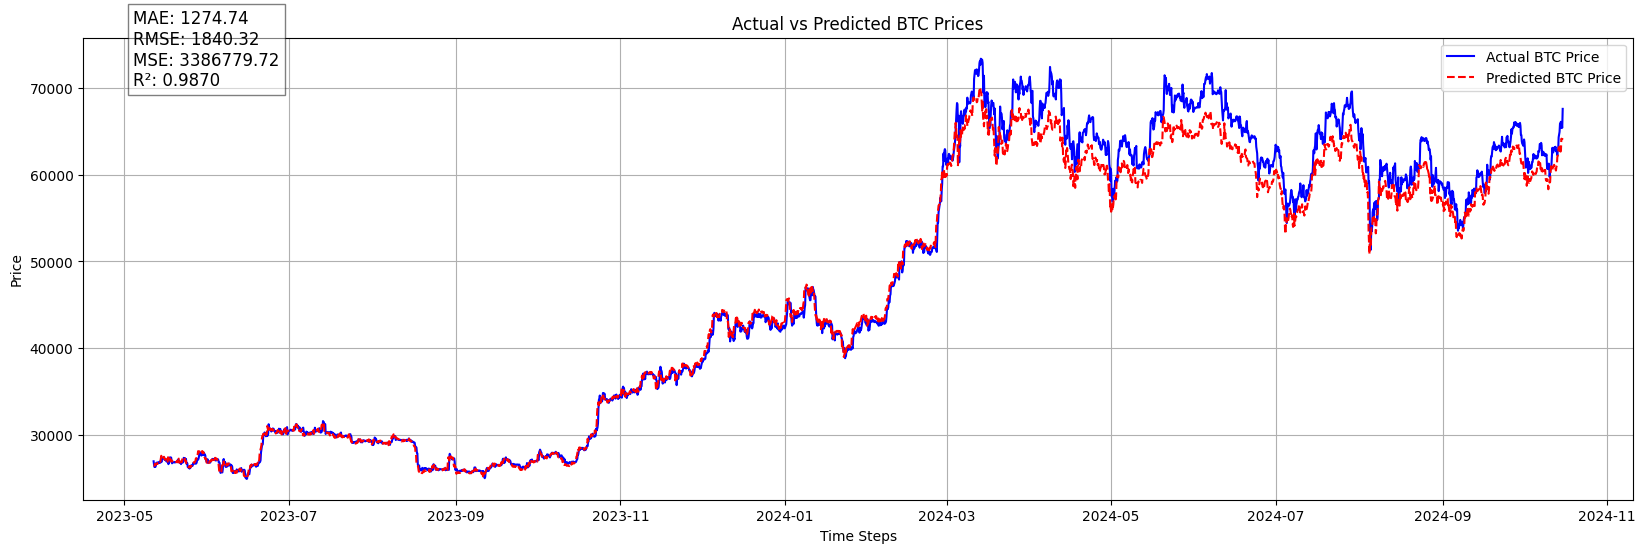

In [382]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test_actual, y_pred_actual)
mse = mean_squared_error(y_test_actual, y_pred_actual)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_actual, y_pred_actual)

textstr = '\n'.join((
    f'MAE: {mae:.2f}',
    f'RMSE: {rmse:.2f}',
    f'MSE: {mse:.2f}',
    f'R²: {r2:.4f}',
))

print(textstr)

plt.figure(figsize=(20, 6))

# plt.plot(y_test_actual, color='blue', label='Actual BTC Price')
# plt.plot(btc_data_tail_df.timestamp, y_test_actual, color='blue', label='Actual BTC Price')
plt.plot(btc_data_tail_df.timestamp, btc_data_tail_df.close, color='blue', label='Actual BTC Price')
plt.plot(btc_data_tail_df.timestamp, y_pred_actual, color='red', linestyle='--', label='Predicted BTC Price')
plt.title('Actual vs Predicted BTC Prices')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

# Display metrics in the plot
plt.gcf().text(0.15, 0.8, textstr, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

plt.show()